# ERA5 Data Processing Pipeline

**Author:** Yeganeh Khabbazian  
**Date:** January 2026  
**Tool:** GitHub Copilot  

## Overview

This notebook implements a **daily atmospheric data processing pipeline** that downloads ERA5 climate reanalysis data, interpolates it to HEALPix equal-area grids, and stores results efficiently in zarr format for time-series analysis.

**Pipeline architecture:**
- **Download:** Retrieve daily ERA5 fields via CDS API (or generate synthetic data in mock mode)
- **Validate:** Detect interrupted downloads by attempting to open files with xarray
- **Process:** Interpolate each time step from lat-lon to HEALPix (NSIDE=8 and NSIDE=16)
- **Append:** Immediately store regridded data to zarr within the daily processing chain
- **Archive:** Move successfully processed files to YYYY/MM/ directory structure
- **Complete:** Skip dates with all expected timesteps already in zarr

The pipeline is **robust to interruptions:** if processing fails mid-run, re-running automatically detects incomplete dates and reprocesses them without duplicating work.

---

## What is ERA5?

**ERA5** (ECMWF Reanalysis v5) is the latest global atmospheric reanalysis from the European Centre for Medium-Range Weather Forecasts, combining observations (satellites, weather stations, aircraft) with model data via data assimilation.

**Key characteristics:**
- **Global coverage** at ~31 km resolution on regular lat-lon grid
- **Sub-daily resolution** (hourly data available; workflow uses configurable times)
- **Multiple variables**: Temperature, pressure, humidity, wind, precipitation, etc.
- **Pressure levels**: 37 levels from surface to stratosphere (surface variables also supported)
- **Data latency**: ~3 months behind real-time
- **Openly available** via Copernicus Climate Data Store (CDS)

---

## What is HEALPix?

**HEALPix** (Hierarchical Equal Area isoLatitude Pixelization) is a spherical tessellation that divides the globe into equal-area pixels with a hierarchical, resolution-independent structure. All pixels cover the same physical area, enabling robust statistical analysis without grid-cell weighting artifacts.

<img src="assets/healpix_view.png" alt="HEALPix view" width="500">

Two-resolution approach used here

---

## Daily Workflow: The Complete Chain

**For each date in the date range:**

1. **Check completeness:** Look in zarr for all expected timesteps. If all present → skip.
2. **Download:** If missing, retrieve from CDS (or create mock file).
3. **Validate:** Attempt to open with xarray; delete invalid/incomplete downloads.
4. **Interpolate:** Load file, extract all time steps and pressure levels, regrid each to HEALPix.
5. **Append to zarr:** Store each timestep immediately (not batched at end).
6. **Archive:** Move processed file to `archive/YYYY/MM/` only if zarr write succeeded.
7. **Repeat:** Move to next date.

**Key design principle:** Zarr append happens within the daily processing chain 

---

## File Organization

Data is organized into **separate mock and real directories** to prevent interference:

 Mock files would otherwise block real downloads—with separate folders, you can toggle `MOCK_MODE` freely without manual cleanup.
To understand the file oraganization better, check out the Readme.md file


---

## Three Invocation Modes

The pipeline supports three ways to specify which dates to process:

### Mode 1: Hardcoded Defaults (Cell 3: all `None`)
```
single_date = None
start_date = None
end_date = None
```
**Result:** Uses `DEFAULT_START_DATE` (2024-12-01) and `DEFAULT_END_DATE` (2024-12-05)

### Mode 2: Single Date (Cell 3: set `single_date`)
```
single_date = datetime(2024, 12, 15)
```
**Result:** Processes only that date

### Mode 3: Date Range (Cell 3: set start_date and end_date)
```
start_date = datetime(2024, 12, 10)
end_date = datetime(2024, 12, 20)
```
**Result:** Processes all dates from start to end 

**Execution:** After configuring, run "Run All". The pipeline executes automatically at the end of the notebook.



## Configuration & Usage


**How to use it:**
- Modify **only Cell 3** (User Parameters)
- Set `MOCK_MODE = True` for fast testing (no API needed)
- Set `MOCK_MODE = False` for real ERA5 downloads (requires CDS API key)
- Run "Run All" → pipeline executes automatically

**CDS API setup** (for real mode only):
1. Register free account: https://cds.climate.copernicus.eu
2. Get API key from Profile 
3. Create `~/.cdsapirc`:
```
url: https://cds.climate.copernicus.eu/api/v2
key: YOUR_UID:YOUR_API_KEY
```


**Verify results:** Run Cell 21 to plot original vs. regridded comparison.

In [ ]:
%matplotlib inline

# ============================================================================
# USER PARAMETERS - EDIT THIS CELL FOR NORMAL USAGE
# ============================================================================

# 1. MOCK MODE: True for testing, False for real CDS API downloads
MOCK_MODE = True

# 2. ERA5 CONFIGURATION
ERA5_CONFIG = {
    'variable': 'relative_humidity',        # ERA5 variable name
    'pressure_levels': [975, 900, 800, 500, 300],  # Pressure levels (hPa)
    'times': ['00:00', '06:00', '12:00', '18:00'],  # Times (UTC)
    'format': 'netcdf',                      # Format: 'netcdf' or 'grib'
    'grid': None,                            # None = global, or [N, W, S, E] for subset
}

# 3. DATE RANGE or Single Date
# Leave all as None to use hardcoded defaults (2024-12-01 to 2024-12-05)
from datetime import datetime, timedelta
single_date = None    # Set to process one specific date
start_date =  None    # Set to specify custom range start
end_date =   None    # Set to specify custom range end
# Default demo range (edit if you want a different built-in default)
DEFAULT_START_DATE = datetime(2024, 12, 1)
DEFAULT_END_DATE = datetime(2024, 12, 5)
# Examples:
# - All None (default): Uses hardcoded range 2024-12-01 to 2024-12-05
# - single_date = datetime(2024, 12, 1): Processes only that date
# - start_date = datetime(2024, 12, 10), end_date = datetime(2024, 12, 15): Custom range


## Function Definitions

The cells below define all functions used by the pipeline. Do not modify these cells.


In [91]:
# ============================================================================
# SETUP & INITIALIZATION 
# ============================================================================


from pathlib import Path
from typing import List, Optional
import logging
import shutil

# Project directories
DATA_DIR_BASE = Path.cwd().parent / 'data_access' / 'data'
DATA_DIR_MOCK = DATA_DIR_BASE / 'mock'
DATA_DIR_REAL = DATA_DIR_BASE / 'real'

# Select data directory based on MOCK_MODE
DATA_DIR = DATA_DIR_MOCK if MOCK_MODE else DATA_DIR_REAL

PROCESSED_DIR_BASE = Path.cwd().parent / 'data_access' / 'processed'
PROCESSED_DIR_MOCK = PROCESSED_DIR_BASE / 'mock'
PROCESSED_DIR_REAL = PROCESSED_DIR_BASE / 'real'
PROCESSED_DIR = PROCESSED_DIR_MOCK if MOCK_MODE else PROCESSED_DIR_REAL

ARCHIVE_DIR_BASE = Path.cwd().parent / 'data_access' / 'archive'
ARCHIVE_DIR_MOCK = ARCHIVE_DIR_BASE / 'mock'
ARCHIVE_DIR_REAL = ARCHIVE_DIR_BASE / 'real'
ARCHIVE_DIR = ARCHIVE_DIR_MOCK if MOCK_MODE else ARCHIVE_DIR_REAL

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('era5_workflow')

# Ensure directories exist
for d in [DATA_DIR, DATA_DIR_MOCK, DATA_DIR_REAL, PROCESSED_DIR, PROCESSED_DIR_MOCK, PROCESSED_DIR_REAL, ARCHIVE_DIR, ARCHIVE_DIR_MOCK, ARCHIVE_DIR_REAL]:
    d.mkdir(parents=True, exist_ok=True)



# ============================================================================
# DETERMINE INVOCATION MODE (based on Cell 1 parameters)
# ============================================================================

if single_date is not None:
    invocation_mode = 'single'
    auto_end_date = None
elif start_date is not None and end_date is not None:
    invocation_mode = 'range'
    auto_end_date = None
else:
    # Invoke with no arguments: auto-detect missing files
    invocation_mode = 'auto'
    auto_end_date = None  # Uses current date
    single_date = None
    start_date = None
    end_date = None

#


In [92]:
# Download routine (uses cdsapi.Client when MOCK_MODE=False)
import json

try:
    import cdsapi
    _HAS_CDSAPI = True
except Exception:
    _HAS_CDSAPI = False


def _is_valid_era5_file(file_path: Path) -> bool:
    """
    Check if ERA5 file is valid by attempting to open it.
    
    Validates that:
    - File can be opened as a NetCDF/GRIB dataset
    - Has data variables
    - Has expected coordinate dimensions (latitude/longitude)
    
    Args:
        file_path: Path to ERA5 file to validate
    
    Returns:
        True if file is valid, False otherwise
    """
    if not _HAS_PROCESSING_LIBS:
        # If can't validate, conservatively assume valid (avoid blocking downloads)
        logger.warning(f"Cannot validate {file_path.name}: xarray not available")
        return True
    
    try:
        with xr.open_dataset(file_path) as ds:
            # Check has data variables
            if len(ds.data_vars) == 0:
                logger.warning(f"File has no data variables: {file_path.name}")
                return False
            
            # Check has coordinate dimensions (latitude/longitude or lat/lon)
            has_coords = False
            for var in ds.data_vars:
                var_coords = ds[var].coords
                if ('latitude' in var_coords and 'longitude' in var_coords) or \
                   ('lat' in var_coords and 'lon' in var_coords):
                    has_coords = True
                    break
            
            if not has_coords:
                logger.warning(f"File missing lat/lon coordinates: {file_path.name}")
                return False
            
            return True
            
    except Exception as e:
        logger.warning(f"File validation failed for {file_path.name}: {e}")
        return False


def download_era5_daily(
    date: datetime,
    output_dir: Path = None,
    mock: bool = None,
) -> Optional[Path]:
    """
    Download a single day of ERA5 data or create a mock file.
    
    Validates existing files before returning to ensure interrupted downloads
    are detected and re-downloaded.
    
    Args:
        date: Date to download
        output_dir: Directory to save file (defaults to DATA_DIR based on MOCK_MODE)
        mock: Override global MOCK_MODE (None = use global setting)
    
    Returns:
        Path to downloaded or created file, or None if failed
    
    Note: This function uses configuration from ERA5_CONFIG.
    """
    if output_dir is None:
        output_dir = DATA_DIR
    if mock is None:
        mock = MOCK_MODE
    
    # Extract configuration from ERA5_CONFIG
    variable = ERA5_CONFIG['variable']
    pressure_levels = ERA5_CONFIG['pressure_levels']
    times = ERA5_CONFIG['times']
    output_format = ERA5_CONFIG['format']
    grid = ERA5_CONFIG['grid']
    
    date_str = date.strftime('%Y%m%d')
    ext = 'nc' if output_format == 'netcdf' else 'grib'
    output_path = output_dir / f"era5_{variable}_{date_str}.{ext}"

    # Check if file exists AND is valid
    if output_path.exists():
        if _is_valid_era5_file(output_path):
            logger.info(f"File already exists and is valid: {output_path}")
            return output_path
        else:
            logger.warning(f"Existing file is invalid or incomplete, will re-download: {output_path}")
            output_path.unlink()  # Delete invalid file

    output_dir.mkdir(parents=True, exist_ok=True)

    if mock:
        # Create an empty mock file
        output_path.touch()
        logger.info(f"[MOCK] Created mock file: {output_path}")
        return output_path

    # Real download path
    if not _HAS_CDSAPI:
        logger.error('cdsapi is not installed in this environment. Install with `pip install cdsapi`')
        return None

    client = cdsapi.Client()
    request = {
        'product_type': 'reanalysis',
        'format': output_format,
        'variable': variable,
        'pressure_level': pressure_levels,
        'date': date.strftime('%Y-%m-%d'),
        'time': times,
    }
    if grid is not None:
        request['grid'] = grid

    try:
        logger.info(f"Downloading {date.strftime('%Y-%m-%d')}: {variable} levels={pressure_levels}")
        client.retrieve('reanalysis-era5-pressure-levels', request, str(output_path))
        
        # Validate downloaded file before returning
        if not _is_valid_era5_file(output_path):
            logger.error(f"Downloaded file failed validation: {output_path}")
            output_path.unlink()  # Clean up invalid download
            return None
        
        logger.info(f"Downloaded to {output_path}")
        return output_path
    except Exception as e:
        logger.error(f"Download failed: {e}")
        # Clean up partial file if it exists
        if output_path.exists():
            output_path.unlink()
        return None


## Processing & Archiving
Process and archive ERA5 files by date (YYYY/MM/ structure).

In [93]:
def archive_file(processed_file: Path, mock: bool = None) -> Optional[Path]:
    """
    Move processed file to archive directory organized by YYYY/MM/.
    
    Args:
        processed_file: Path to processed file
        mock: Use mock or real archive directory (None = use MOCK_MODE)
    
    Returns:
        Path to archived file, or None if failed
    """
    if mock is None:
        mock = MOCK_MODE
    
    archive_dir = ARCHIVE_DIR_MOCK if mock else ARCHIVE_DIR_REAL
    
    if not processed_file.exists():
        logger.error(f"Processed file not found: {processed_file}")
        return None
    
    try:
        # Extract date from filename (e.g., processed_era5_relative_humidity_20241201.nc)
        filename = processed_file.name
        # Find YYYYMMDD pattern in filename
        import re
        date_match = re.search(r'(\d{8})', filename)
        if not date_match:
            logger.error(f"Could not extract date from filename: {filename}")
            return None
        
        date_str = date_match.group(1)
        yyyy = date_str[:4]
        mm = date_str[4:6]
        
        # Create archive subdirectory
        archive_subdir = archive_dir / yyyy / mm
        archive_subdir.mkdir(parents=True, exist_ok=True)
        
        # Move file to archive
        archived_path = archive_subdir / filename
        shutil.move(str(processed_file), str(archived_path))
        
        logger.info(f"Archived to: {archived_path}")
        return archived_path
        
    except Exception as e:
        logger.error(f"Failed to archive {processed_file}: {e}")
        return None


In [94]:
def append_to_zarr(
    data_nside8: np.ndarray,
    data_nside16: np.ndarray,
    time_value: np.datetime64,
    pressure_levels: List[int],
):
    """
    Append HEALPix interpolated data to zarr store.

    Args:
        data_nside8: HEALPix data at NSIDE=8 resolution (levels, npix)
        data_nside16: HEALPix data at NSIDE=16 resolution (levels, npix)
        time_value: Timestamp as numpy.datetime64[ns] (no timezone conversions)
        pressure_levels: List of pressure levels

    Returns:
        Paths to the NSIDE=8 and NSIDE=16 zarr stores
    """
    if not _HAS_PROCESSING_LIBS:
        logger.warning("Cannot save to zarr: missing dependencies")
        return None, None

    variable = ERA5_CONFIG['variable']
    zarr_path_8 = ZARR_DIR / f'{variable}_nside8.zarr'
    zarr_path_16 = ZARR_DIR / f'{variable}_nside16.zarr'

    # Ensure datetime64[ns] precision (no roundtrip conversions)
    time_value = np.datetime64(time_value, 'ns')

    # Process NSIDE=8
    _append_single_zarr(zarr_path_8, data_nside8, time_value, pressure_levels, nside=8)

    # Process NSIDE=16
    _append_single_zarr(zarr_path_16, data_nside16, time_value, pressure_levels, nside=16)

    logger.info(f"Appended {time_value} to zarr stores (NSIDE 8 & 16)")
    return zarr_path_8, zarr_path_16


def _append_single_zarr(zarr_path: Path, data: np.ndarray, time_value: np.datetime64,
                        pressure_levels: List[int], nside: int):
    """Helper to append to a single zarr store (v2/v3 compatible).

    Uses zarr.open() with the path. Creates datasets if they don't exist
    and appends or updates the time slice as needed.
    """
    npix = hp.nside2npix(nside)
    n_times = len(ERA5_CONFIG['times'])
    chunk_time = max(1, n_times * 1)  # 1 day worth of time steps

    # Open or create zarr group using path string
    zarr_path.parent.mkdir(parents=True, exist_ok=True)
    root = zarr.open(str(zarr_path), mode='a')

    # Validate input data shape
    expected_shape = (len(pressure_levels), npix)
    if data.shape != expected_shape:
        raise ValueError(
            f"Data shape mismatch for NSIDE={nside}: "
            f"expected {expected_shape} (levels={len(pressure_levels)}, npix={npix}), "
            f"got {data.shape}"
        )

    # Ensure data is float32 before writing to f4 dataset
    data = data.astype(np.float32, copy=False)

    # Create datasets if missing
    if 'data' not in root:
        chunks = (chunk_time, len(pressure_levels), npix)
        root.create_dataset(
            'data',
            shape=(0, len(pressure_levels), npix),
            chunks=chunks,
            dtype='f4',
        )
        root.create_dataset('time', shape=(0,), chunks=(chunk_time,), dtype='datetime64[ns]')
        root['pressure_level'] = np.array(pressure_levels, dtype='i4')
        root.attrs['nside'] = nside
        root.attrs['variable'] = ERA5_CONFIG['variable']
        root.attrs['npix'] = npix
        logger.info(f"Created zarr store: {zarr_path} (NSIDE={nside}, npix={npix})")

    # Validate pressure level consistency
    if 'pressure_level' in root:
        stored_levels = root['pressure_level'][:].tolist()
        incoming_levels = list(pressure_levels)
        if stored_levels != incoming_levels:
            raise ValueError(
                f"Pressure level mismatch for {zarr_path.name}: "
                f"stored={stored_levels}, incoming={incoming_levels}"
            )

    data_arr = root['data']
    time_arr = root['time']

    if data_arr.shape[0] != time_arr.shape[0]:
        raise ValueError(
            f"Data/time length mismatch in {zarr_path}: "
            f"data={data_arr.shape[0]} time={time_arr.shape[0]}"
        )

    # Read existing times for existence check
    try:
        existing_times = time_arr[:]
    except Exception:
        existing_times = np.array([], dtype='datetime64[ns]')

    # Ensure time_value and existing_times have consistent ns precision
    time_value = np.datetime64(time_value, 'ns')
    if existing_times.size > 0:
        existing_times = existing_times.astype('datetime64[ns]')

    # Update existing or append new
    if existing_times.size > 0 and np.any(existing_times == time_value):
        idx = int(np.where(existing_times == time_value)[0][0])
        data_arr[idx, :, :] = data
        logger.info(f"Updated existing time {time_value} in {zarr_path.name}")
    else:
        # Append by resizing along axis 0 (zarr v2/v3 compatible)
        # Use new shape tuple instead of axis parameter (compatible with latest zarr)
        new_len = data_arr.shape[0] + 1
        data_arr.resize((new_len, data_arr.shape[1], data_arr.shape[2]))
        data_arr[new_len - 1, :, :] = data
        time_arr.resize((new_len,))
        time_arr[new_len - 1] = time_value
        logger.info(f"Appended new time {time_value} to {zarr_path.name}")

## Zarr Storage
Save interpolated data to zarr format with appropriate chunking strategy.

In [95]:
try:
    import healpy as hp
    import xarray as xr
    import numpy as np
    import zarr
    from scipy.interpolate import griddata
    _HAS_PROCESSING_LIBS = True
except ImportError as e:
    _HAS_PROCESSING_LIBS = False
    logger.warning(f"Processing libraries not available: {e}")
    logger.warning("Install with: pip install healpy xarray zarr scipy netcdf4")

# Zarr storage paths (separate by mock/real mode)
# Robust project root detection: walk up to .git, fallback to git CLI
import subprocess

PROJECT_ROOT = Path.cwd().resolve()

# Walk upward until we find a .git marker (dir or file)
root_candidate = PROJECT_ROOT
while not (root_candidate / ".git").exists() and root_candidate.parent != root_candidate:
    root_candidate = root_candidate.parent

if (root_candidate / ".git").exists():
    PROJECT_ROOT = root_candidate
else:
    # Fallback: ask git (works even if .git is elsewhere via worktrees)
    try:
        result = subprocess.run(
            ["git", "rev-parse", "--show-toplevel"],
            capture_output=True,
            text=True,
            cwd=Path.cwd(),
        )
        if result.returncode == 0:
            PROJECT_ROOT = Path(result.stdout.strip()).resolve()
    except Exception:
        pass

ZARR_DIR_BASE = PROJECT_ROOT / "zarr_data"
ZARR_DIR_MOCK = ZARR_DIR_BASE / "mock"
ZARR_DIR_REAL = ZARR_DIR_BASE / "real"
ZARR_DIR = ZARR_DIR_MOCK if MOCK_MODE else ZARR_DIR_REAL
ZARR_DIR.mkdir(parents=True, exist_ok=True)

logger.info(f"Zarr stores will be created at: {ZARR_DIR}")

def _get_lat_lon_coords(data_array: 'xr.DataArray'):
    coords = data_array.coords
    if 'latitude' in coords and 'longitude' in coords:
        lat_name, lon_name = 'latitude', 'longitude'
    elif 'lat' in coords and 'lon' in coords:
        lat_name, lon_name = 'lat', 'lon'
    else:
        raise ValueError(
            "Expected coordinates named ('latitude', 'longitude') or ('lat', 'lon'). "
            f"Found: {list(coords.keys())}"
        )
    lats = coords[lat_name].values
    lons = coords[lon_name].values
    return lats, lons, lat_name, lon_name

def interpolate_to_healpix(data_array: 'xr.DataArray', nside: int = 8) -> 'np.ndarray':
    """
    Interpolate a lat-lon gridded data array to HEALPix grid with periodic longitude handling.
    
    Args:
        data_array: xarray DataArray with lat/lon coordinates (ERA5 uses [0, 360) convention)
        nside: HEALPix NSIDE parameter (8 or 16)
    
    Returns:
        1D array of values at HEALPix pixel centers (float32)
    """
    if not _HAS_PROCESSING_LIBS:
        raise ImportError("healpy and related libraries are required for interpolation")
    
    # Get lat/lon from data array
    lats, lons, _, _ = _get_lat_lon_coords(data_array)

    # ERA5 uses [0, 360) longitude convention - normalize to ensure this
    lons = lons % 360.0

    # Create mesh grid
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    # Flatten the grids and data
    lon_flat = lon_grid.flatten()
    lat_flat = lat_grid.flatten()
    data_flat = data_array.values.flatten()
    
    # Remove NaN values
    mask = ~np.isnan(data_flat)
    lon_flat = lon_flat[mask]
    lat_flat = lat_flat[mask]
    data_flat = data_flat[mask]
    
    # Guard against all-NaN input after masking
    npix = hp.nside2npix(nside)
    if data_flat.size == 0:
        logger.warning(f"All input data is NaN for NSIDE={nside}, returning NaN array")
        return np.full(npix, np.nan, dtype=np.float32)
    
    # Fix dateline adjacency issue: duplicate source points with lon±360 shifts.
    # This allows griddata to see neighbors across the 0/360 boundary, preventing
    # interpolation artifacts at the dateline (where 359° and 1° are physically adjacent).
    lon_flat_periodic = np.concatenate([lon_flat - 360.0, lon_flat, lon_flat + 360.0])
    lat_flat_periodic = np.concatenate([lat_flat, lat_flat, lat_flat])
    data_flat_periodic = np.concatenate([data_flat, data_flat, data_flat])
    
    # Get HEALPix pixel centers and convert to lat/lon in [0, 360)
    theta_hp, phi_hp = hp.pix2ang(nside, np.arange(npix))
    lat_hp = 90.0 - np.degrees(theta_hp)
    lon_hp = np.degrees(phi_hp) % 360.0
    
    # Interpolate using griddata with periodic longitude handling.
    # Note: This treats (lat, lon) as a flat 2D plane, which is an approximation
    # for spherical data. Works well for dense ERA5 grids but introduces small errors.
    # See README for discussion of interpolation method and limitations.
    healpix_data = griddata(
        (lat_flat_periodic, lon_flat_periodic),
        data_flat_periodic,
        (lat_hp, lon_hp),
        method='linear',
        fill_value=np.nan
    )
    
    return healpix_data


2026-01-21 12:04:33,904 - INFO - Zarr stores will be created at: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/zarr_data/real


## HEALPix Interpolation
Interpolate lat-lon grid data to HEALPix grid with NSIDE=8 and NSIDE=16. Requires `healpy`, `xarray`, and `zarr`.

In [96]:
def _load_and_interpolate_file_ntimes(input_file: Path):
    """
    Load NetCDF file and interpolate to HEALPix grids, preserving all time steps.
    
    Supports both pressure-level and surface variables.
    
    Returns:
        Tuple of (data_nside8_list, data_nside16_list, actual_times, actual_levels)
        - data lists: one array per time step, each shaped (n_levels, npix)
        - actual_times: list of numpy datetime64 values from the dataset
        - actual_levels: list of pressure level values (or [0] for surface variables)
    """
    if not _HAS_PROCESSING_LIBS:
        return None, None, None, None
    
    try:
        # Use context manager to guarantee ds.close() on all code paths
        with xr.open_dataset(input_file) as ds:
            variable = ERA5_CONFIG['variable']
            
            # Step 1: Find the data variable
            # Prefer ERA5_CONFIG['variable'] if it exists, else find var with lat/lon dims
            data_var = None
            if variable in ds.data_vars:
                data_var = variable
            else:
                # Find variable with latitude and longitude in its dims
                candidates = []
                for var in ds.data_vars:
                    var_dims = ds[var].dims
                    if 'latitude' in var_dims and 'longitude' in var_dims:
                        candidates.append(var)
                
                if len(candidates) == 0:
                    logger.error(f"No data variable found with lat/lon dimensions. Available: {list(ds.data_vars)}")
                    return None, None, None, None
                elif len(candidates) > 1:
                    logger.error(f"Multiple candidate variables found: {candidates}. Specify which in ERA5_CONFIG['variable']")
                    return None, None, None, None
                else:
                    data_var = candidates[0]
                    logger.info(f"Variable '{variable}' not found, using '{data_var}' from file")
            
            # Step 2: Get the data array and detect dimensions
            data = ds[data_var]
            dims = data.dims
            
            # Detect time dimension (required)
            time_dim = None
            for td in ['time', 'valid_time', 'validTime']:
                if td in dims:
                    time_dim = td
                    break
            
            if time_dim is None:
                logger.error(f"No time dimension found in {data_var}. Dims: {dims}")
                return None, None, None, None
            
            # Detect level dimension (optional - not present for surface variables)
            level_dim = None
            for ld in ['level', 'pressure_level', 'isobaricInhPa']:
                if ld in dims:
                    level_dim = ld
                    break
            
            is_surface_var = (level_dim is None)
            
            # Step 3: Extract actual time values from dataset
            # Robust extraction: try coords first, fall back to dimension variable
            actual_times = data.coords[time_dim].values if time_dim in data.coords else data[time_dim].values
            n_times = len(actual_times)
            n_times_expected = len(ERA5_CONFIG['times'])
            
            if n_times != n_times_expected:
                logger.warning(f"Expected {n_times_expected} time steps, found {n_times}. Will process available times.")
            
            # Step 4: Handle pressure levels
            if is_surface_var:
                # Surface variable: no levels, create placeholder
                actual_levels = [0]
                logger.info(f"Surface variable detected (no level dimension): {data_var}")
            else:
                # Pressure-level variable: select by coordinate value
                requested_levels = ERA5_CONFIG.get('pressure_levels', None)
                # Robust extraction: try coords first, fall back to dimension variable
                available_levels = data.coords[level_dim].values if level_dim in data.coords else data[level_dim].values
                
                if requested_levels is not None:
                    # Select only requested levels by coordinate value
                    try:
                        data = data.sel({level_dim: requested_levels})
                        # Validate: ensure xarray preserved requested order
                        selected_levels = data[level_dim].values if level_dim in data.coords else data.coords[level_dim].values
                        if not np.array_equal(selected_levels, np.array(requested_levels)):
                            logger.warning(f"xarray reordered levels: requested {requested_levels}, got {selected_levels.tolist()}. Reindexing...")
                            data = data.reindex({level_dim: requested_levels})
                        actual_levels = list(requested_levels)
                        logger.info(f"Selected {len(actual_levels)} pressure levels: {actual_levels}")
                    except KeyError as e:
                        logger.error(f"Requested pressure levels {requested_levels} not all found in file. Available: {available_levels.tolist()}")
                        return None, None, None, None
                else:
                    # Process all levels in file
                    actual_levels = available_levels.tolist()
                    logger.info(f"No pressure_levels specified, processing all {len(actual_levels)} levels from file")
            
            # Step 5: Interpolate each time step
            data_nside8_list = []
            data_nside16_list = []
            
            for time_idx in range(n_times):
                level_data_8 = []
                level_data_16 = []
                
                if is_surface_var:
                    # Surface variable: single "level"
                    slice_data = data.isel({time_dim: time_idx})
                    hp8 = interpolate_to_healpix(slice_data, nside=8)
                    hp16 = interpolate_to_healpix(slice_data, nside=16)
                    level_data_8.append(hp8)
                    level_data_16.append(hp16)
                else:
                    # Pressure-level variable: loop over levels
                    for level_idx in range(len(actual_levels)):
                        slice_data = data.isel({time_dim: time_idx, level_dim: level_idx})
                        hp8 = interpolate_to_healpix(slice_data, nside=8)
                        hp16 = interpolate_to_healpix(slice_data, nside=16)
                        level_data_8.append(hp8)
                        level_data_16.append(hp16)
                
                data_nside8_list.append(np.array(level_data_8))
                data_nside16_list.append(np.array(level_data_16))
                
                time_str = str(actual_times[time_idx])
                logger.debug(f"Interpolated {time_str}: NSIDE8 {np.array(level_data_8).shape}, NSIDE16 {np.array(level_data_16).shape}")
            
            # Validate output shapes before return (Issue G runtime validation)
            npix_8 = hp.nside2npix(8)
            npix_16 = hp.nside2npix(16)
            for idx, (d8, d16) in enumerate(zip(data_nside8_list, data_nside16_list)):
                expected_shape_8 = (len(actual_levels), npix_8)
                expected_shape_16 = (len(actual_levels), npix_16)
                if d8.shape != expected_shape_8:
                    raise ValueError(f"Time {idx}: NSIDE8 shape {d8.shape} != expected {expected_shape_8}")
                if d16.shape != expected_shape_16:
                    raise ValueError(f"Time {idx}: NSIDE16 shape {d16.shape} != expected {expected_shape_16}")
            
            logger.info(f"Interpolated {input_file.name} to HEALPix: {n_times} time steps, {len(actual_levels)} levels")
            return data_nside8_list, data_nside16_list, actual_times, actual_levels
        
    except Exception as e:
        logger.error(f"Failed to load/interpolate {input_file}: {e}")
        import traceback
        logger.error(traceback.format_exc())
        return None, None, None, None


def process_daily_data(input_file: Path, output_dir: Path = None, mock: bool = None) -> Optional[Path]:
    """
    Daily batch processing: download → interpolate → save to zarr → process file
    
    This function implements the assignment requirement:
    "saving shall be done within the daily processing chain"
    
    DAILY WORKFLOW (per assignment):
    1. Interpolate to HEALPix (NSIDE=8 and NSIDE=16) for all timesteps
    2. **IMMEDIATELY APPEND TO ZARR** within this daily batch (not after all downloads)
    3. Create processed output file
    
    Args:
        input_file: Path to downloaded ERA5 file
        output_dir: Directory to save processed file (defaults based on mock)
        mock: Use mock mode (None = use global MOCK_MODE)
    
    Returns:
        Path to processed file if successful, or None if zarr write failed
    """
    if mock is None:
        mock = MOCK_MODE
    
    if output_dir is None:
        output_dir = PROCESSED_DIR_MOCK if mock else PROCESSED_DIR_REAL
    
    output_dir.mkdir(parents=True, exist_ok=True)
    
    if not input_file.exists():
        logger.error(f"Input file not found: {input_file}")
        return None
    
    variable = ERA5_CONFIG['variable']
    out = output_dir / f"processed_{input_file.name}"
    
    # Create processed file reference (just a marker, actual data is in zarr)
    shutil.copy2(input_file, out)
    logger.info(f"Created processed file: {out}")
    
    # NOW DO THE DAILY BATCH PROCESSING: interpolate + immediately save to zarr
    if not _HAS_PROCESSING_LIBS:
        logger.warning("Cannot process to zarr: missing libraries")
        return out  # Return processed file anyway
    
    try:
        # Load and interpolate all timesteps for this date
        logger.info(f"Processing daily batch: loading and interpolating HEALPix data...")
        result = _load_and_interpolate_file_ntimes(input_file)
        
        if result[0] is None:
            logger.error(f"Failed to interpolate {input_file.name}")
            # Delete processed file on interpolation failure
            out.unlink(missing_ok=True)
            return None
        
        data_list_8, data_list_16, actual_times, actual_levels = result
        
        # DAILY BATCH: immediately append all timesteps to zarr
        # Use actual timestamps and levels from the dataset (not config assumptions)
        n_times = len(data_list_8)
        
        logger.info(f"DAILY BATCH: Appending {n_times} timesteps to zarr (NSIDE 8 & 16)...")
        for time_idx in range(n_times):
            # Pass numpy datetime64 directly to avoid timezone bugs
            timestamp_np = actual_times[time_idx].astype('datetime64[ns]')
            
            # Validate timestamp: skip NaT values
            if np.isnat(timestamp_np):
                logger.warning(f"Skipping invalid timestamp at index {time_idx}: NaT")
                continue
            
            # Append this timestep to zarr immediately (daily chain, not batch)
            append_to_zarr(
                data_list_8[time_idx],
                data_list_16[time_idx],
                timestamp_np,
                actual_levels
            )
        
        logger.info(f"✓ Daily batch complete: {n_times} timesteps appended to zarr")
        return out  # Only return processed file if zarr append succeeded
        
    except Exception as e:
        logger.error(f"Error in daily batch processing: {e}")
        import traceback
        logger.error(traceback.format_exc())
        # Delete processed file on zarr append failure
        out.unlink(missing_ok=True)
        logger.warning(f"Deleted processed file due to zarr failure: {out}")
        return None

## Pipeline orchestration (functions)
These functions let you process a single date, or a date range. Pass `mock=True` to skip actual downloads.

In [97]:
def check_day_completeness(date: datetime, archive_dir: Path = None) -> dict:
    """
    Check if a day has ALL required timesteps in the archive.
    
    Args:
        date: Date to check
        archive_dir: Archive directory to search in (auto-detects mock/real if None)
    
    Returns:
        Dictionary with keys:
        - 'complete': bool (True if all expected timesteps present)
        - 'found': int (number of timesteps found in archive)
        - 'expected': int (number of expected timesteps)
        - 'missing': list of missing time strings
        - 'archive_path': Path where files were found
    """
    if archive_dir is None:
        archive_dir = ARCHIVE_DIR_REAL  # Default to real archive for checking
    
    variable = ERA5_CONFIG['variable']
    n_times_expected = len(ERA5_CONFIG['times'])
    yyyy = date.strftime('%Y')
    mm = date.strftime('%m')
    
    archive_date_folder = archive_dir / yyyy / mm
    date_str = date.strftime('%Y%m%d')
    ext = 'nc' if ERA5_CONFIG['format'] == 'netcdf' else 'grib'
    
    # Look for archived processed file with this date
    if not archive_date_folder.exists():
        return {
            'complete': False,
            'found': 0,
            'expected': n_times_expected,
            'missing': ERA5_CONFIG['times'],
            'archive_path': archive_date_folder
        }
    
    # Check if the processed file exists in archive
    processed_file = archive_date_folder / f"processed_era5_{variable}_{date_str}.{ext}"
    
    if not processed_file.exists():
        return {
            'complete': False,
            'found': 0,
            'expected': n_times_expected,
            'missing': ERA5_CONFIG['times'],
            'archive_path': archive_date_folder
        }
    
    # File exists - NOW CHECK ZARR STORE FOR ACTUAL TIMESTEP COUNT
    # This ensures we don't consider a day "complete" if it only has partial data
    if not _HAS_PROCESSING_LIBS:
        # If can't check zarr, conservatively assume incomplete
        logger.warning(f"Cannot verify timestep completeness for {date_str} (missing zarr libs)")
        return {
            'complete': False,
            'found': 0,
            'expected': n_times_expected,
            'missing': ERA5_CONFIG['times'],
            'archive_path': archive_date_folder
        }
    
    try:
        # Determine which zarr directory based on archive_dir type (not string inference)
        # Check if this is mock archive by comparing to known mock archive path
        is_mock_archive = (archive_dir == ARCHIVE_DIR_MOCK)
        zarr_dir = ZARR_DIR_MOCK if is_mock_archive else ZARR_DIR_REAL
        
        # Check both NSIDE=8 and NSIDE=16 stores (both must have all timesteps)
        zarr_path_8 = zarr_dir / f'{variable}_nside8.zarr'
        zarr_path_16 = zarr_dir / f'{variable}_nside16.zarr'
        
        if not zarr_path_8.exists() or not zarr_path_16.exists():
            # Zarr store doesn't exist yet - definitely not complete
            return {
                'complete': False,
                'found': 0,
                'expected': n_times_expected,
                'missing': ERA5_CONFIG['times'],
                'archive_path': archive_date_folder
            }
        
        # Open zarr stores and check for this date's timesteps
        # Only need to check one store since both are written together by append_to_zarr
        store = zarr.open(str(zarr_path_8), mode='r')
        all_times = store['time'][:]
        # Ensure nanosecond precision to match datetime64[ns] encoding used elsewhere
        all_times = all_times.astype('datetime64[ns]')
        
        # Count how many timesteps exist for this specific date
        found_times = []
        missing_times = []
        
        for time_str in ERA5_CONFIG['times']:
            # Create expected timestamp for this date + time
            expected_timestamp = datetime.strptime(f"{date_str} {time_str}", '%Y%m%d %H:%M')
            # Force ns precision to avoid precision mismatch when comparing
            expected_np_time = np.datetime64(expected_timestamp, 'ns')
            
            # Check if this timestamp exists in zarr
            if expected_np_time in all_times:
                found_times.append(time_str)
            else:
                missing_times.append(time_str)
        
        n_found = len(found_times)
        is_complete = (n_found == n_times_expected)
        
        if not is_complete:
            logger.info(f"Date {date_str} incomplete: {n_found}/{n_times_expected} timesteps in zarr (missing: {missing_times})")
        
        return {
            'complete': is_complete,
            'found': n_found,
            'expected': n_times_expected,
            'missing': missing_times,
            'archive_path': archive_date_folder
        }
    
    except Exception as e:
        logger.warning(f"Error checking zarr completeness for {date_str}: {e}")
        # On error, conservatively assume incomplete
        return {
            'complete': False,
            'found': 0,
            'expected': n_times_expected,
            'missing': ERA5_CONFIG['times'],
            'archive_path': archive_date_folder
        }


def should_skip_date(date: datetime, mock: bool = None) -> bool:
    """
    Determine if a date should be skipped (already fully processed).
    
    Only skips if:
    1. File exists in archive AND
    2. All expected timesteps are present
    
    Args:
        date: Date to check
        mock: Check mock archive if True, real if False (None = use MOCK_MODE)
    
    Returns:
        True if date should be skipped, False if it should be processed
    """
    if mock is None:
        mock = MOCK_MODE
    
    archive_dir = ARCHIVE_DIR_MOCK if mock else ARCHIVE_DIR_REAL
    completeness = check_day_completeness(date, archive_dir)
    
    if completeness['complete']:
        logger.info(f"Skipping {date.strftime('%Y-%m-%d')}: all {completeness['expected']} timesteps already in zarr")
        return True
    
    if completeness['found'] > 0:
        logger.info(f"Processing {date.strftime('%Y-%m-%d')}: incomplete ({completeness['found']}/{completeness['expected']} timesteps in zarr)")
    else:
        logger.info(f"Processing {date.strftime('%Y-%m-%d')}: not yet processed (0 timesteps in zarr)")
    
    return False


def process_single_date(date: datetime, mock: bool = None, skip_if_complete: bool = True) -> bool:
    """
    Process a single date: download → process (with HEALPix & zarr) → archive.
    
    Args:
        date: Date to process
        mock: Override global MOCK_MODE (None = use global setting)
        skip_if_complete: Skip if day is already complete in archive (default: True)
    
    Returns:
        True if successful or skipped as complete, False otherwise
    """
    if mock is None:
        mock = MOCK_MODE
    
    # Skip if day is already complete in archive
    if skip_if_complete and should_skip_date(date, mock=mock):
        return True  # Treat as success since it's already done
    
    ds = download_era5_daily(date=date, mock=mock)
    if ds is None:
        return False
    
    processed = process_daily_data(ds, mock=mock)
    if processed is None:
        return False
    
    archived = archive_file(processed, mock=mock)
    return archived is not None


def process_date_range(start_date: datetime, end_date: datetime, mock: bool = None):
    """
    Process a range of dates with intelligent skipping of complete dates.
    
    Args:
        start_date: Start date (inclusive)
        end_date: End date (inclusive)
        mock: Override global MOCK_MODE (None = use global setting)
    
    Returns:
        Dictionary with counts:
        - 'processed': dates that were actually processed
        - 'skipped': dates that were already complete
        - 'failed': dates that failed to process
    """
    if mock is None:
        mock = MOCK_MODE
    
    current = start_date
    results = {'processed': 0, 'skipped': 0, 'failed': 0}
    
    while current <= end_date:
        # Check if day should be skipped (already complete)
        if should_skip_date(current, mock=mock):
            results['skipped'] += 1
        else:
            # Process the date
            ok = process_single_date(current, mock=mock, skip_if_complete=False)  # Already checked
            if ok:
                results['processed'] += 1
            else:
                results['failed'] += 1
        
        current += timedelta(days=1)
    
    return results

In [98]:
def auto_process_missing(
    end_date: Optional[datetime] = None,
    mock: bool = None,
):
    """
    Find the oldest incomplete/missing file and process from that date to end_date.
    
    Intelligently skips dates that are already complete in archive with all timesteps.
    Reprocesses incomplete dates (some timesteps present).
    
    Args:
        end_date: End date (None = use current date)
        mock: Override global MOCK_MODE (None = use global setting)
    
    Returns:
        Dictionary with 'success', 'failed', and 'skipped' counts
    
    This is the "invoke with no arguments" option: sets parameters in Cell 2,
    run the notebook, and this function finds and processes all missing/incomplete data.
    """
    if mock is None:
        mock = MOCK_MODE
    if end_date is None:
        end_date = datetime.utcnow()
    
    variable = ERA5_CONFIG['variable']
    missing_date = find_oldest_missing_file(
        start_date=DEFAULT_START_DATE,
        end_date=end_date,
        mock=mock,
        variable=variable
    )
    
    if missing_date is None:
        logger.info("All files are complete with all timesteps. Nothing to process.")
        return {'success': 0, 'failed': 0, 'skipped': 0}
    
    logger.info(f"Processing from {missing_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    return process_date_range(missing_date, end_date, mock=mock)


## Auto-process missing files
Process from the oldest missing file to the end date.

In [99]:
def find_oldest_missing_file(
    start_date: datetime = DEFAULT_START_DATE,
    end_date: datetime = DEFAULT_END_DATE,
    mock: bool = None,
    variable: str = ERA5_CONFIG['variable']
) -> Optional[datetime]:
    """
    Scan the date range and return the first incomplete/missing date.
    A date is considered "missing" if:
    1. Not yet archived, OR
    2. Archived but incomplete (missing some timesteps)
    
    Returns None if all dates are complete.
    """
    if mock is None:
        mock = MOCK_MODE
    
    current = start_date
    ext = 'nc' if ERA5_CONFIG['format'] == 'netcdf' else 'grib'
    archive_dir = ARCHIVE_DIR_MOCK if mock else ARCHIVE_DIR_REAL
    
    while current <= end_date:
        # Check archive for completeness
        completeness = check_day_completeness(current, archive_dir)
        
        # If incomplete or missing, this is the oldest missing date
        if not completeness['complete']:
            logger.info(f"Found incomplete/missing date: {current.strftime('%Y-%m-%d')} (found {completeness['found']}/{completeness['expected']} timesteps)")
            return current
        
        current += timedelta(days=1)
    
    logger.info("No missing files found")
    return None

## Pipeline Control Flow

The entire ERA5 workflow is encapsulated in a single function, run_era5_pipeline(), which serves as the main entry point for downloading, processing, and archiving daily data.

In [100]:
def run_era5_pipeline(single_date=None, start_date=None, end_date=None, mock=None):
    """
    Main pipeline function: download, process, and archive ERA5 data.
    
    This function encapsulates the entire workflow in a single call.
    It downloads ERA5 data for the specified date range (or hardcoded defaults),
    interpolates to HEALPix grids, and stores in zarr format.
    
    AUTOMATIC FEATURES (no user action required):
    ✓ Skips dates that are already complete (all timesteps verified in zarr)
    ✓ Reprocesses incomplete dates (missing some timesteps)
    ✓ Uses check_day_completeness() to verify zarr stores before processing
    
    Args:
        single_date (datetime, optional): Process only this specific date.
            Takes precedence over start_date/end_date if provided.
        start_date (datetime, optional): Start of date range. 
            Default: Uses HARDCODED_START_DATE (2024-12-01)
        end_date (datetime, optional): End of date range. 
            Default: Uses HARDCODED_END_DATE (2024-12-05)
        mock (bool, optional): Use mock mode (True) or real CDS API (False). 
            Default: Uses global MOCK_MODE from Cell 3
    
    Returns:
        dict: Results with keys 'processed', 'skipped', 'failed'

        )
    """
    # Handle single_date parameter (takes precedence)
    if single_date is not None:
        start_date = single_date
        end_date = single_date
    
    # Use hardcoded defaults from setup cell if not provided
    if start_date is None:
        start_date = DEFAULT_START_DATE
    if end_date is None:
        end_date = DEFAULT_END_DATE
    if mock is None:
        mock = MOCK_MODE
    
    # Log pipeline configuration
    logger.info("\n" + "=" * 70)
    logger.info("ERA5 PIPELINE EXECUTION")
    logger.info("=" * 70)
    logger.info(f"Start date: {start_date.date()}")
    logger.info(f"End date: {end_date.date()}")
    
    # This automatically handles:
    # 1. Checking each date for completeness (all timesteps in zarr)
    # 2. Skipping complete dates
    # 3. Processing incomplete/missing dates
    results = process_date_range(start_date, end_date, mock=mock)
    
    # Log results
    logger.info("\n" + "=" * 70)
    logger.info("PIPELINE RESULTS")
    logger.info("=" * 70)
    logger.info(f"✓ Processed: {results['processed']} days")
    logger.info(f"⊘ Skipped (already complete): {results['skipped']} days")
    logger.info(f"✗ Failed: {results['failed']} days")
    logger.info("=" * 70 + "\n")
    
    return results


# ============================================================================
# EXECUTE THE PIPELINE
# ============================================================================
# Run the pipeline with parameters from Cell 3 or with hardcoded defaults

if single_date is not None:
    # Single date mode
    logger.info(f"Running pipeline for single date: {single_date.date()}")
    results = run_era5_pipeline(single_date=single_date)
elif start_date is not None and end_date is not None:
    # Range mode
    logger.info(f"Running pipeline with specified date range")
    results = run_era5_pipeline(start_date=start_date, end_date=end_date)
else:
    # Default mode: use hardcoded defaults
    logger.info(f"Running pipeline with hardcoded defaults (2024-12-01 to 2024-12-05)")
    results = run_era5_pipeline()

2026-01-21 12:04:33,954 - INFO - Running pipeline for single date: 2026-01-01
2026-01-21 12:04:33,957 - INFO - 
2026-01-21 12:04:33,958 - INFO - ERA5 PIPELINE EXECUTION
2026-01-21 12:04:33,964 - INFO - ======================================================================
2026-01-21 12:04:33,965 - INFO - Start date: 2026-01-01
2026-01-21 12:04:33,966 - INFO - End date: 2026-01-01
2026-01-21 12:04:33,967 - INFO - Processing 2026-01-01: not yet processed (0 timesteps in zarr)
2026-01-21 12:04:34,980 - INFO - Downloading 2026-01-01: relative_humidity levels=[975, 900, 800, 500, 300]
2026-01-21 12:04:35,465 INFO Request ID is cc0c93f8-f519-4e32-99d4-69beeee0ce21
2026-01-21 12:04:35,465 - INFO - Request ID is cc0c93f8-f519-4e32-99d4-69beeee0ce21
2026-01-21 12:04:35,645 INFO status has been updated to accepted
2026-01-21 12:04:35,645 - INFO - status has been updated to accepted
2026-01-21 12:04:50,143 INFO status has been updated to running
2026-01-21 12:04:50,143 - INFO - status has been up

KeyboardInterrupt: 

## Plots
This section configures plotting dependencies and provides routines to create comparison figures of original ERA5 lat‑lon fields vs. HEALPix regridded output.

Purpose
- Set up matplotlib and optional visualization libraries.
- Provide `load_and_plot_comparison()` to generate side‑by‑side plots: original ERA5, HEALPix NSIDE=8, HEALPix NSIDE=16.
- Save publication‑quality PNGs to data_access/results.

Dependencies
- Required: matplotlib, healpy, xarray, numpy.
- Optional (enhancements): cmocean (better colormaps), cartopy (coastlines/axes).
- The code sets flags: `_HAS_PLOTTING`, `_HAS_CMOCEAN`, `_HAS_CARTOPY` and falls back gracefully if optional packages are missing.

Usage
- Run this cell to enable plotting support.
- Call:
  `load_and_plot_comparison(variable=ERA5_CONFIG['variable'], pressure_level_idx=0, mock=MOCK_MODE, save_plots=True)`
- Output: PNG files saved to `data_access/results` and interactive display in the notebook.

Notes
- Requires at least two time samples in the zarr store.
- Uses physical vmin/vmax for known variables (e.g., 0–100 % for relative humidity); otherwise computes color range from data.
- If projview is unavailable in the installed healpy version, update healpy (`pip install --upgrade healpy`).

2026-01-21 11:59:57,888 - INFO - cmocean installed and available
2026-01-21 11:59:57,944 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:00,260 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-02_00UTC.png


2026-01-21 11:59:57,888 - INFO - cmocean installed and available
2026-01-21 11:59:57,944 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:00,260 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-02_00UTC.png


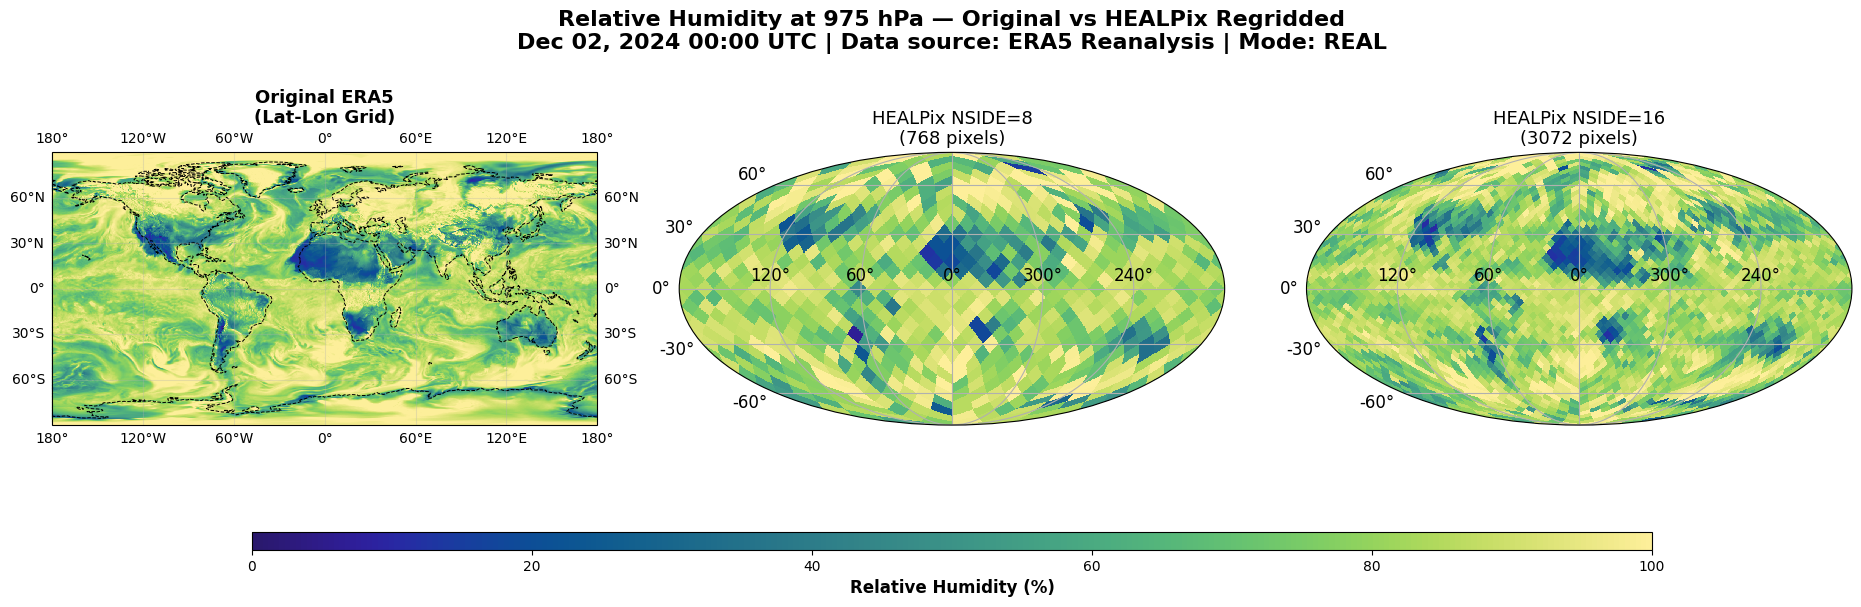

2026-01-21 11:59:57,888 - INFO - cmocean installed and available
2026-01-21 11:59:57,944 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:00,260 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-02_00UTC.png


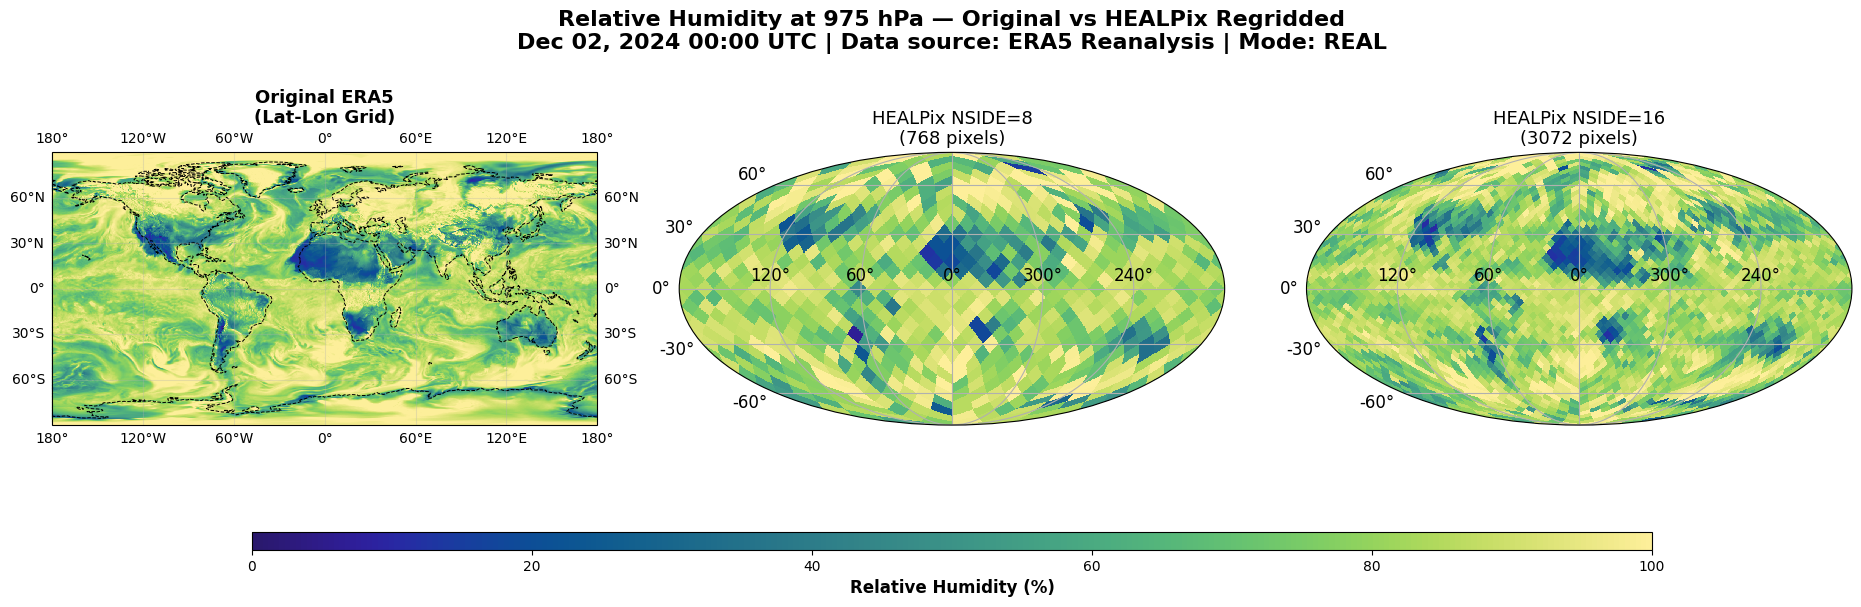

2026-01-21 12:00:00,888 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:03,215 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-03_12UTC.png


2026-01-21 11:59:57,888 - INFO - cmocean installed and available
2026-01-21 11:59:57,944 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:00,260 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-02_00UTC.png


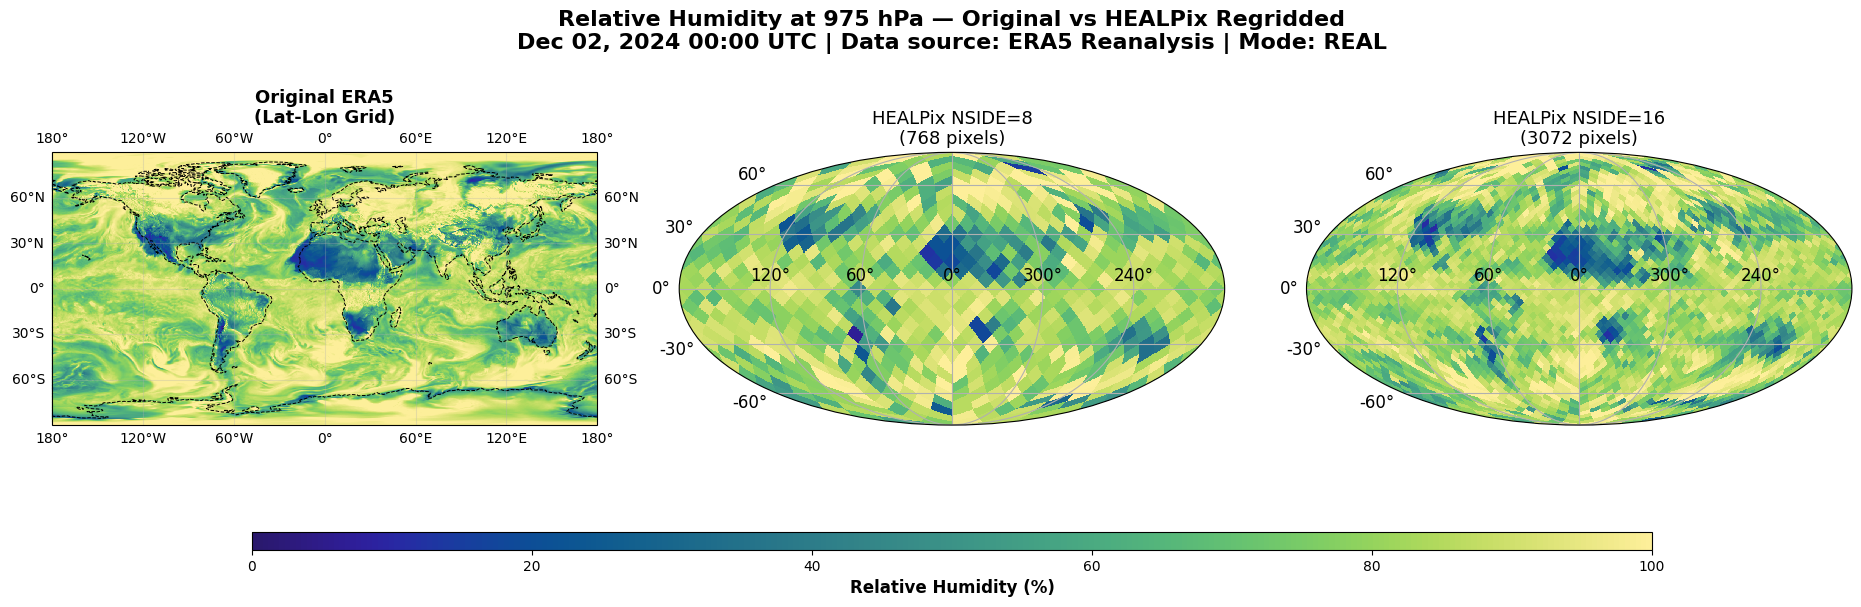

2026-01-21 12:00:00,888 - INFO - Using physical range for Relative Humidity: [0, 100] %
2026-01-21 12:00:03,215 - INFO - Plot saved to: /Users/yeganehkhabbazian/Projects/Earth_System/earth-system-data-processing/data_access/results/comparison_relative_humidity_real_2024-12-03_12UTC.png


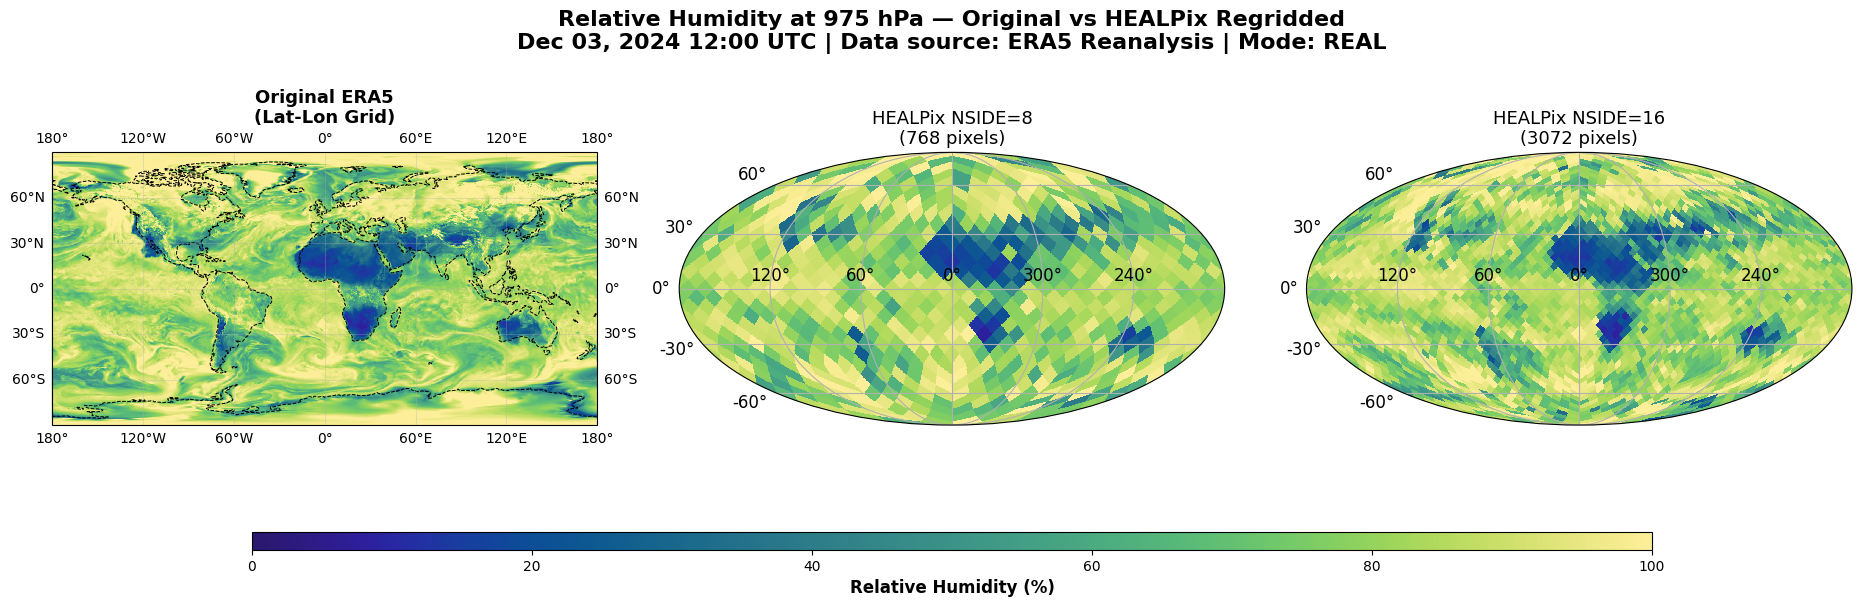

2026-01-21 12:00:03,792 - INFO - Created 2 comparison plots successfully


In [ ]:
try:
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.colors import Normalize
    import matplotlib.gridspec as gridspec
    _HAS_PLOTTING = True
except ImportError:
    _HAS_PLOTTING = False
    logger.warning("Install matplotlib for plotting: pip install matplotlib")

# Try to import cmocean and register colormaps
try:
    import cmocean
    _HAS_CMOCEAN = True
    logger.info("cmocean installed and available")
except ImportError:
    _HAS_CMOCEAN = False
    logger.warning("cmocean not installed. Install with: pip install cmocean")
    logger.warning("Falling back to matplotlib colormaps")

# Try to import cartopy for coastlines
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    _HAS_CARTOPY = True
except ImportError:
    _HAS_CARTOPY = False
    logger.warning("cartopy not installed. Coastlines will not be added. Install with: pip install cartopy")


# Variable metadata for labels, units, and physically meaningful ranges
# Use cmocean if available, otherwise fall back to matplotlib colormaps
VARIABLE_DISPLAY = {
    'relative_humidity': {'label': 'Relative Humidity', 'unit': '%', 'cmap': 'cmo.haline' if _HAS_CMOCEAN else 'BuPu', 'vmin': 0, 'vmax': 100},
    'r': {'label': 'Relative Humidity', 'unit': '%', 'cmap': 'cmo.haline' if _HAS_CMOCEAN else 'BuPu', 'vmin': 0, 'vmax': 100},
    'temperature': {'label': 'Temperature', 'unit': 'K', 'cmap': 'RdYlBu_r', 'vmin': None, 'vmax': None},
    't': {'label': 'Temperature', 'unit': 'K', 'cmap': 'RdYlBu_r', 'vmin': None, 'vmax': None},
    'geopotential': {'label': 'Geopotential', 'unit': 'm²/s²', 'cmap': 'cmo.matter' if _HAS_CMOCEAN else 'gray', 'vmin': None, 'vmax': None},
    'z': {'label': 'Geopotential', 'unit': 'm²/s²', 'cmap': 'cmo.matter' if _HAS_CMOCEAN else 'gray', 'vmin': None, 'vmax': None},
}





def _format_timestamp(timestamp):
    """Format numpy datetime64 to readable string."""
    dt_str = np.datetime_as_string(timestamp, unit='h')
    # Format: "2024-12-02 00:00" -> "Dec 02, 2024 00:00 UTC"
    try:
        from datetime import datetime
        dt = datetime.fromisoformat(dt_str.replace('T', ' ').replace('Z', ''))
        return dt.strftime('%b %d, %Y %H:%M UTC')
    except Exception:
        return dt_str


def _format_timestamp_filename(timestamp):
    """Format numpy datetime64 for filename: 2024-12-02_00UTC"""
    dt_str = np.datetime_as_string(timestamp, unit='h')
    try:
        from datetime import datetime
        dt = datetime.fromisoformat(dt_str.replace('T', ' ').replace('Z', ''))
        return dt.strftime('%Y-%m-%d_%H') + 'UTC'
    except Exception:
        return dt_str.replace('T', '_').replace(':', '') + 'UTC'


def load_and_plot_comparison(variable: str = ERA5_CONFIG['variable'], pressure_level_idx: int = 0, mock: bool = None, save_plots: bool = True):
    """
    Create publication-quality comparison plots: Original ERA5 vs HEALPix regridded.

    Creates TWO separate plots (one per timestep) with a single shared colorbar per plot.
    Uses healpy's projview() for beautiful Mollweide projections with graticule.

    DATA SOURCES:
    - Regridded data: FROM ZARR (zarr_data/mock or zarr_data/real)
    - Original data: FROM ARCHIVE (archive/mock or archive/real)

    Args:
        variable: ERA5 variable name (default from ERA5_CONFIG)
        pressure_level_idx: Pressure level index to visualize
        mock: Use mock or real data (None = use global MOCK_MODE)
        save_plots: Save plots to file (default True) or just display
    """
    if mock is None:
        mock = MOCK_MODE

    if not _HAS_PROCESSING_LIBS or not _HAS_PLOTTING:
        logger.error("Missing dependencies for plotting")
        return

    # Import projview from healpy's new visualization module
    try:
        from healpy.newvisufunc import projview
    except ImportError:
        logger.error("healpy.newvisufunc.projview not available. Update healpy: pip install --upgrade healpy")
        return

    # Select correct zarr directory based on mock/real mode
    zarr_dir = ZARR_DIR_MOCK if mock else ZARR_DIR_REAL
    archive_dir = ARCHIVE_DIR_MOCK if mock else ARCHIVE_DIR_REAL

    # Create results directory for saving plots
    results_dir = Path.cwd().parent / 'data_access' / 'results'
    results_dir.mkdir(parents=True, exist_ok=True)

    # Open zarr stores (DATA SOURCE: ZARR)
    zarr_path_8 = zarr_dir / f'{variable}_nside8.zarr'
    zarr_path_16 = zarr_dir / f'{variable}_nside16.zarr'

    if not zarr_path_8.exists():
        logger.error(f"Zarr store not found: {zarr_path_8}")
        return
    if not zarr_path_16.exists():
        logger.error(f"Zarr store not found: {zarr_path_16}")
        return

    store_8 = zarr.open(str(zarr_path_8), mode='r')
    store_16 = zarr.open(str(zarr_path_16), mode='r')

    # Get variable display metadata
    var_meta = VARIABLE_DISPLAY.get(variable, {
        'label': variable.replace('_', ' ').title(), 
        'unit': '', 
        'cmap': 'viridis',
        'vmin': None,
        'vmax': None
    })
    var_label = var_meta['label']
    var_unit = var_meta['unit']
    var_cmap = var_meta['cmap']
    physical_vmin = var_meta['vmin']  # e.g., 0 for relative humidity
    physical_vmax = var_meta['vmax']  # e.g., 100 for relative humidity

    # Get pressure level value for title
    pressure_levels = store_8['pressure_level'][:]
    pressure_val = pressure_levels[pressure_level_idx] if len(pressure_levels) > pressure_level_idx else pressure_level_idx

    # Need at least two time samples
    times = store_8['time'][:]
    n_times = len(times)
    if n_times < 2:
        logger.error("Need at least 2 time samples for comparison")
        return

    time_indices = [0, n_times // 2]
    mode_str = "MOCK" if mock else "REAL"

    # =========================================================================
    # CREATE SEPARATE PLOT FOR EACH TIMESTEP
    # =========================================================================
    for plot_idx, time_idx in enumerate(time_indices):
        timestamp = times[time_idx]
        time_label = _format_timestamp(timestamp)
        time_filename = _format_timestamp_filename(timestamp)

        # Load HEALPix data from ZARR
        data_8 = np.array(store_8['data'][time_idx, pressure_level_idx, :])
        data_16 = np.array(store_16['data'][time_idx, pressure_level_idx, :])

        # Build original file path from timestamp
        date_str = np.datetime_as_string(timestamp, unit='D').replace('-', '')
        yyyy = date_str[:4]
        mm = date_str[4:6]
        ext = 'nc' if ERA5_CONFIG['format'] == 'netcdf' else 'grib'
        original_file = archive_dir / yyyy / mm / f"processed_era5_{variable}_{date_str}.{ext}"

        # =====================================================================
        # STEP 1: Load ALL data sources first to compute proper shared vmin/vmax
        # =====================================================================
        data_orig_array = None
        lons = None
        lats = None
        ds_orig = None
        load_error = None
        
        if original_file.exists():
            try:
                ds_orig = xr.open_dataset(original_file)

                # Detect time dimension
                time_dim_name = None
                for td in ['time', 'valid_time', 'validTime']:
                    if td in ds_orig.dims:
                        time_dim_name = td
                        break
                if time_dim_name is None:
                    raise KeyError("No time dimension found")

                orig_times = ds_orig.coords[time_dim_name].values
                time_diffs = np.abs(orig_times - timestamp)
                closest_idx = int(np.argmin(time_diffs))

                # Handle variable name aliases
                var_name = variable
                if variable not in ds_orig.data_vars:
                    aliases = {'relative_humidity': 'r', 'temperature': 't', 'geopotential': 'z'}
                    if variable in aliases and aliases[variable] in ds_orig.data_vars:
                        var_name = aliases[variable]
                    else:
                        raise KeyError(f"Variable '{variable}' not found")

                # Handle pressure levels
                level_dim = None
                for ld in ['level', 'pressure_level', 'isobaricInhPa']:
                    if ld in ds_orig[var_name].dims:
                        level_dim = ld
                        break

                if level_dim is not None:
                    data_orig = ds_orig[var_name].isel({time_dim_name: closest_idx, level_dim: pressure_level_idx})
                else:
                    data_orig = ds_orig[var_name].isel({time_dim_name: closest_idx})

                # Extract arrays for plotting
                lons = data_orig.coords['longitude'].values
                lats = data_orig.coords['latitude'].values
                data_orig_array = data_orig.values

            except Exception as e:
                logger.warning(f"Could not load original data: {e}")
                load_error = e
                if ds_orig is not None:
                    ds_orig.close()
                    ds_orig = None

        # Compute color scale: use physical limits if specified, otherwise auto-range
        if physical_vmin is not None and physical_vmax is not None:
            # Use physically meaningful range (e.g., 0-100 for relative humidity)
            vmin = physical_vmin
            vmax = physical_vmax
            logger.info(f"Using physical range for {var_label}: [{vmin}, {vmax}] {var_unit}")
        else:
            # Auto-detect from data
            vmin_list = [np.nanmin(data_8), np.nanmin(data_16)]
            vmax_list = [np.nanmax(data_8), np.nanmax(data_16)]
            
            if data_orig_array is not None:
                vmin_list.append(np.nanmin(data_orig_array))
                vmax_list.append(np.nanmax(data_orig_array))
            
            vmin = min(vmin_list)
            vmax = max(vmax_list)

        # =====================================================================
        # STEP 2: Create figure with 1 row × 3 columns + shared colorbar
        # =====================================================================
        fig = plt.figure(figsize=(20, 6), facecolor='white')
        
        # Main title
        fig.suptitle(
            f'{var_label} at {pressure_val} hPa — Original vs HEALPix Regridded\n'
            f'{time_label} | Data source: ERA5 Reanalysis | Mode: {mode_str}',
            fontsize=16, fontweight='bold', y=0.98
        )

        # =====================================================================
        # COLUMN 1: Original ERA5 (lat-lon grid)
        # =====================================================================
        # Create subplot with Cartopy projection if available for coastlines
        if _HAS_CARTOPY:
            ax_orig = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
        else:
            ax_orig = fig.add_subplot(1, 3, 1)
        
        if data_orig_array is not None:
            # Clip data to physical range if specified
            if physical_vmin is not None and physical_vmax is not None:
                data_orig_array_clipped = np.clip(data_orig_array, physical_vmin, physical_vmax)
            else:
                data_orig_array_clipped = data_orig_array
            
            # For Cartopy axes, we need to transform data coordinates
            if _HAS_CARTOPY:
                im = ax_orig.pcolormesh(lons, lats, data_orig_array_clipped, cmap=var_cmap, vmin=vmin, vmax=vmax, 
                                       shading='auto', transform=ccrs.PlateCarree())
            else:
                im = ax_orig.pcolormesh(lons, lats, data_orig_array_clipped, cmap=var_cmap, vmin=vmin, vmax=vmax, shading='auto')
            
            if _HAS_CARTOPY:
                ax_orig.coastlines(linewidth=0.7, color='black', linestyle='--')
                ax_orig.gridlines(draw_labels=True, alpha=0.3)
            else:
                ax_orig.set_xlim(0, 360)
                ax_orig.set_ylim(-90, 90)
                ax_orig.grid(True, alpha=0.3, linestyle='--')
            
            ax_orig.set_xlabel('Longitude (°)', fontsize=11)
            ax_orig.set_ylabel('Latitude (°)', fontsize=11)
            ax_orig.set_title('Original ERA5\n(Lat-Lon Grid)', fontsize=13, fontweight='bold')
            
            # Close dataset after plotting
            if ds_orig is not None:
                ds_orig.close()
        elif load_error:
            ax_orig.text(0.5, 0.5, f'Original data unavailable\n{str(load_error)[:30]}', 
                        ha='center', va='center', transform=ax_orig.transAxes, fontsize=11)
            ax_orig.set_title('Original ERA5 (error)', fontsize=13)
        else:
            ax_orig.text(0.5, 0.5, 'Original data not found\nin archive', 
                        ha='center', va='center', transform=ax_orig.transAxes, fontsize=11)
            ax_orig.set_title('Original ERA5 (not found)', fontsize=13)

        # =====================================================================
        # COLUMN 2: HEALPix NSIDE=8 using projview (Mollweide)
        # =====================================================================
        # Clip data to physical range
        if physical_vmin is not None and physical_vmax is not None:
            data_8_clipped = np.clip(data_8, physical_vmin, physical_vmax)
        else:
            data_8_clipped = data_8
        
        projview(
            data_8_clipped,
            fig=fig.number,
            sub=(1, 3, 2),
            projection_type='mollweide',
            flip='geo',  # Geographic convention (east right)
            cmap=var_cmap,
            min=vmin,
            max=vmax,
            cbar=False,  # We'll add a shared colorbar later
            title='HEALPix NSIDE=8\n(768 pixels)',
            graticule=True,
            graticule_labels=True,
            fontsize={'title': 13},
        )

        # =====================================================================
        # COLUMN 3: HEALPix NSIDE=16 using projview (Mollweide)
        # =====================================================================
        # Clip data to physical range
        if physical_vmin is not None and physical_vmax is not None:
            data_16_clipped = np.clip(data_16, physical_vmin, physical_vmax)
        else:
            data_16_clipped = data_16
        
        projview(
            data_16_clipped,
            fig=fig.number,
            sub=(1, 3, 3),
            projection_type='mollweide',
            flip='geo',
            cmap=var_cmap,
            min=vmin,
            max=vmax,
            cbar=False,  # We'll add a shared colorbar later
            title='HEALPix NSIDE=16\n(3072 pixels)',
            graticule=True,
            graticule_labels=True,
            fontsize={'title': 13},
        )

        # =====================================================================
        # Add ONE shared colorbar for all 3 plots at the bottom
        # =====================================================================
        # Create a ScalarMappable for the colorbar
        norm = Normalize(vmin=vmin, vmax=vmax)
        sm = cm.ScalarMappable(cmap=var_cmap, norm=norm)
        sm.set_array([])
        
        # Add colorbar below all subplots
        cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f'{var_label} ({var_unit})', fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)

        # Adjust layout
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.18, wspace=0.15)

        # Save plot to file with descriptive timestamp
        if save_plots:
            plot_file = results_dir / f"comparison_{variable}_{mode_str.lower()}_{time_filename}.png"
            plt.savefig(plot_file, dpi=150, bbox_inches='tight', facecolor='white')
            logger.info(f"Plot saved to: {plot_file}")

        plt.show()
    
    logger.info(f"Created {len(time_indices)} comparison plots successfully")


# ============================================================================
# EXECUTE PLOTTING
# ============================================================================
# Load 2 time samples and create comparison plots of original vs regridded
load_and_plot_comparison(variable=ERA5_CONFIG['variable'], pressure_level_idx=0, mock=MOCK_MODE, save_plots=True)